In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os
import torch
import torch.nn

from datetime import datetime
from math import copysign
from numpy.core.defchararray import isnumeric
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.nn import Module, Sequential, Linear, Dropout, LeakyReLU, Sigmoid, LSTM
from torch.nn.utils.rnn import pad_sequence
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset

# Data preperation - common

In [2]:
"""
Large value span differences do not work well with neural networks.
Take the `column_name` column with numeric values in the `df` dataframe
and replace its values with their base 2 logarithm.

1 is added to the number in order to prevent large negative values when 
taking the log of 0 < x << 1.
"""
logarithimize = lambda x: copysign(1, x) * log(abs(x) + 1, 2)

def encoded_ip_to_binary(ip: str) -> list[bool]:
    """
    Transform encoded IPs e.g. 'MW.YB.50.64' into a unique, repeatable list of `0`s and `1`s.
    Each segment divided by a '.' will be transformed to an integer, which will be later encoded as a 
    10 bit number.
    If a segment is numeric (e.g. '50'), it will be parsed immediately to an int.
    If a segment is non-numeric (e.g. 'MW') it will be converted to a number by a following function:
    `f(s) = 256 + ordinal(s[0]) * ordinal(s[1])`, where `ordinal(c)` assigns `0` to `a`, `1` to `b` etc.
    256 is added to avoid collisions with numerical segments.
    
    All segments are then transformed into 10 bit binary numbers.
    
    Since there are 26 letter available in the alfabet, the maximum value of the encoded segment is:
    256 + 26*26 = 932, which means 10 bits are needed to encode segment, a total of 40 bits for each IP address.
    """
    ordinal = lambda c: ord(c) - ord('A')
    
    if type(ip) is not str:
        return [False]*40
    
    result = []
    for part in ip.split('.'):
        try:
            numeric = int(part) if isnumeric(part) else 256 + ordinal(part[0])*ordinal(part[1])
        except IndexError:
            # It might happen that an invalid IP is passed, e.g. 'RZ..202.16'
            numeric = 1023
        binary_str = bin(numeric).replace('0b', '').rjust(10, '0')
        binary_arr = [b=='1' for b in binary_str]
        
        result.extend(binary_arr)

    return result

def port_to_binary(port: str) -> list[bool]:
    """
    Convert port from int to a binary number.
    The maximum socket (port) number is 65535 - 16 bits are needed to encode all.
    """
    if type(port) is not str:
        return [False]*16
    
    binary = bin(int(port)).replace('0b', '').rjust(16, '0')
    return [b=='1' for b in binary]

# Data preperation 

Since only the `cybersecurity_training.csv` dataset is labeled, it will be split into two parts:
\- training subset
\- test subset (in order to evaluate the proposed algorithm).

In [3]:
from math import log

cybersecurity_training = pd.read_csv('data/cybersecurity_training.csv', sep='|')
cybersecurity_test = pd.read_csv('data/cybersecurity_test.csv', sep='|', usecols=['alert_ids'])

y = cybersecurity_training.pop('notified')
X = cybersecurity_training

train_alert_ids = set(X['alert_ids'].unique())
test_alert_ids = set(cybersecurity_test['alert_ids'].unique())

present_alert_ids = list(train_alert_ids.union(test_alert_ids))

def alert_id_to_int(alert_id: int):
    try:
        return present_alert_ids.index(alert_id)
    except ValueError:
        return -1

print(f'{len(present_alert_ids)=}')

# Encrypted client ids will not be used.
X.pop('client_code')

X.head()

len(present_alert_ids)=59427


,alert_ids,categoryname,ip,ipcategory_name,ipcategory_scope,parent_category,grandparent_category,overallseverity,timestamp_dist,start_hour,...,thrcnt_week,thrcnt_day,p6,p9,p5m,p5w,p5d,p8m,p8w,p8d
0,Nhq,Attack,YT.LB.32.21,INTERNET,Internet,7,A,3,65684,8,...,4160,675,1,0,2,1,1,1,1,1
1,XZt,Exploit,192.SL.UK.94,PRIV-192,Private network,1,A,5,1188030,1,...,9,2,4,12,3,2,2,2,1,1
2,bBz,Attack,YT.LB.38.21,INTERNET,Internet,7,A,4,43716,14,...,3788,628,1,0,2,2,1,2,2,1
3,ZNr,Attack,JX.NY.13.20,INTERNET,Internet,7,A,4,0,20,...,565,96,0,0,2,2,2,2,2,2
4,poV,Attack,YT.LB.32.21,INTERNET,Internet,7,A,4,2401,14,...,2790,632,1,0,1,1,1,1,1,1


In [4]:
COLUMNS_TO_LOGARITHMIZE = [
    'timestamp_dist', 'correlatedcount', 'srcip_cd', 'dstip_cd', 'srcport_cd', 'dstport_cd', 'thrcnt_month', 'thrcnt_week', 'thrcnt_day', 'alerttype_cd', 'direction_cd', 'eventname_cd', 'severity_cd', 'reportingdevice_cd', 'devicetype_cd', 'devicevendor_cd', 'domain_cd', 'protocol_cd', 'username_cd', 'srcipcategory_cd', 'dstipcategory_cd'
]

COLUMNS_TO_ONEHOTIZE = [
    'categoryname', 'ipcategory_name', 'ipcategory_scope', 'parent_category', 'grandparent_category', 'overallseverity', 'weekday', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'score', 'isiptrusted', 'untrustscore', 'flowscore', 'trustscore', 'enforcementscore', 'dstipcategory_dominate', 'srcipcategory_dominate', 'dstportcategory_dominate', 'srcportcategory_dominate', 'p6', 'p9', 'p5m', 'p5w', 'p5d', 'p8m', 'p8w', 'p8d'
]

# Encode alert_ids to int (str values are invalid in torch tensors)
X['alert_ids'] = X['alert_ids'].apply(alert_id_to_int)

# Transform IPs into binary
X_ip_bin = pd.DataFrame(
    data=[encoded_ip_to_binary(ip) for ip in X.pop('ip')],
    columns=[f'ip{i}' for i in range(40)],
    index=X.index
)
X = pd.concat([X, X_ip_bin], axis=1)

# Logarithmize columns
for column_name in COLUMNS_TO_LOGARITHMIZE:
    X[column_name] = X[column_name].apply(logarithimize)

# Encode columns to one-hot
X = pd.get_dummies(X, columns=COLUMNS_TO_ONEHOTIZE, prefix_sep='$', dummy_na=True, dtype=bool)

X.head()

,alert_ids,timestamp_dist,start_hour,start_minute,start_second,correlatedcount,srcip_cd,dstip_cd,srcport_cd,dstport_cd,...,p8w$2.0,p8w$3.0,p8w$4.0,p8w$5.0,p8w$nan,p8d$1.0,p8d$2.0,p8d$3.0,p8d$4.0,p8d$nan
0,839,16.003276,8,14,34,6.129283,5.247928,1.000000,6.087463,1.584963,...,False,False,False,False,False,True,False,False,False,False
1,24700,20.180141,1,0,2,12.372593,1.000000,5.554589,12.212800,4.321928,...,False,False,False,False,False,True,False,False,False,False
2,25316,15.415907,14,44,5,8.438792,8.204571,1.000000,8.430453,1.584963,...,True,False,False,False,False,True,False,False,False,False
3,51034,0.000000,20,33,40,1.000000,0.000000,0.000000,0.000000,0.000000,...,True,False,False,False,False,False,True,False,False,False
4,7344,11.230020,14,36,11,1.000000,1.000000,1.000000,1.000000,1.000000,...,False,False,False,False,False,True,False,False,False,False


# Data preperation - localized alerts (log stack)

In [5]:
LOCALIZED_ALERTS_PATH = 'data/localized_alerts_data.csv'
DUMPS_DIR = 'dumps'
LOCALIZED_ALERTS_DUMP_PATH = f'{DUMPS_DIR}/localized_alerts_data_dump.pkl'

localized_alerts_by_alert_id: dict[str, pd.DataFrame]

if os.path.exists(LOCALIZED_ALERTS_DUMP_PATH):
    print(f'Processed localized alerts found at {LOCALIZED_ALERTS_DUMP_PATH}. Loading dump.')
    with open(LOCALIZED_ALERTS_DUMP_PATH, 'rb') as handle:
        localized_alerts_by_alert_id = pickle.load(handle)
        
else:
    print(f'Processed localized alerts dump not found. Preprocessing data...')
    localized_alerts = pd.read_csv(
        LOCALIZED_ALERTS_PATH, sep='|', 
        dtype={
            'alert_ids': str, 'alerttype': str, 'devicetype': str, 'reportingdevice_code': str, 'devicevendor_code': str, 'srcip': str, 'dstip': str, 'srcipcategory': str, 'dstipcategory': str, 'srcport': str, 'dstport': str, 'srcportcategory': str, 'dstportcategory': str, 'direction': str, 'alerttime': int, 'severity': int, 'count': int, 'domain': int, 'protocol': str, 'username': int, 'signature': int
        }
    )

    # Drop unused
    localized_alerts.drop(columns=['reportingdevice_code'], inplace=True)
    
    COLUMNS_TO_LOGARITHMIZE = [
        'alerttime', 'count'
    ]
    COLUMNS_TO_ONEHOTIZE = [
        'protocol', 'alerttype', 'devicetype', 'devicevendor_code', 'srcipcategory', 'dstipcategory', 'srcportcategory', 'dstportcategory'
    ]
    COLUMNS_TO_IP_BINARY = [
        'srcip', 'dstip'
    ]
    COLUMNS_TO_PORT_BINARY = [
        'srcport', 'dstport'
    ]
    
    def simplify_web_protocol(protocol: str):
        if type(protocol) is not str:
            return 'other'

        if protocol == '-':
            return 'other'
    
        protocol = protocol.lower()
    
        if 'udp' in protocol:
            return 'udp'
        elif 'tcp' in protocol:
            return 'tcp'
        elif 'https' in protocol:
            return 'https'
        elif 'http' in protocol:
            return 'http'
        elif 'dns' in protocol:
            return 'dns'

        return 'other'

    localized_alerts['protocol'] = localized_alerts['protocol'].apply(simplify_web_protocol)
    
    for column_name in COLUMNS_TO_LOGARITHMIZE:
        localized_alerts[column_name] = localized_alerts[column_name].apply(logarithimize)
    print('[1/6] Logarithmizing completed.')

    localized_alerts = pd.get_dummies(localized_alerts, columns=COLUMNS_TO_ONEHOTIZE, prefix_sep='$', dummy_na=True, dtype=bool)
    print('[2/6] Onehot completed.')

    ip_bin_dfs = []
    for i, column_name in enumerate(COLUMNS_TO_IP_BINARY):
        print(f'[3/6] Converting IPs to binary... {round(i / len(COLUMNS_TO_IP_BINARY) * 100)}%')
        ip_bin = pd.DataFrame(
            data=[encoded_ip_to_binary(ip) for ip in localized_alerts.pop(column_name)], 
            columns=[f'{column_name}{i}' for i in range(40)],
            index=localized_alerts.index
        )
        ip_bin_dfs.append(ip_bin)
    print('[3/6] IPs to binary conversion completed.')

    port_bin_dfs = []
    for i, column_name in enumerate(COLUMNS_TO_PORT_BINARY):
        print(f'[4/6] Converting ports to binary... {round(i / len(COLUMNS_TO_PORT_BINARY) * 100)}%')
        port_bin = pd.DataFrame(
            data=[port_to_binary(ip) for ip in localized_alerts.pop(column_name)], 
            columns=[f'{column_name}{i}' for i in range(16)],
            index=localized_alerts.index
        )
        port_bin_dfs.append(port_bin)
    print('[4/6] Ports to binary conversion completed.')

    localized_alerts = pd.concat([localized_alerts] + ip_bin_dfs + port_bin_dfs, axis=1)
    del ip_bin, ip_bin_dfs, port_bin, port_bin_dfs
    print('[5/6] Dataframe concatenated.')

    localized_alerts_by_alert_id = {}
    for i, alert_id in enumerate(present_alert_ids):
        if i % (len(present_alert_ids) // 20) == 0:
            print(f'[6/6] Splitting dataframe by alert ids... {round(i / len(present_alert_ids) * 100)}%')
        localized_alerts_part = localized_alerts[localized_alerts['alert_ids'] == alert_id]
        if len(localized_alerts_part) == 0:
            continue
        localized_alerts_part.drop(columns=['alert_ids'], inplace=True)
        localized_alerts_by_alert_id[alert_id_to_int(alert_id)] = localized_alerts_part
    print('[6/6] Dataframe split by alert ids.')

    del localized_alerts

    os.makedirs(DUMPS_DIR, exist_ok=True)

    with open(LOCALIZED_ALERTS_DUMP_PATH, 'wb') as file:
        pickle.dump(
            obj=localized_alerts_by_alert_id,
            file=file,
            protocol=pickle.HIGHEST_PROTOCOL
        )
        print(f'Processed localized alerts saved at {LOCALIZED_ALERTS_DUMP_PATH}')
        
next(iter(localized_alerts_by_alert_id.values())).head()

Processed localized alerts found at dumps/localized_alerts_data_dump.pkl. Loading dump.


,direction,alerttime,severity,count,domain,username,signature,protocol$dns,protocol$http,protocol$https,...,dstport6,dstport7,dstport8,dstport9,dstport10,dstport11,dstport12,dstport13,dstport14,dstport15
5483893,5,0.0,1,2.0,0,1,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Neural net solutions

In [6]:
dtype = torch.float32

class DenseNet(Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = Sequential(
            Linear(input_size, 512),
            Dropout(.3),
            LeakyReLU(.2),

            Linear(512, 512 + 256),
            Dropout(.3),
            LeakyReLU(.2),

            Linear(512 + 256, 256+128),
            Dropout(.3),
            LeakyReLU(.2),

            Linear(256+128, 128),
            Dropout(.3),
            LeakyReLU(.2),

            Linear(128, 64),
            LeakyReLU(.2),

            Linear(64, 16),
            LeakyReLU(.2),

            Linear(16, 1),
            # Sigmoid()
        ).type(dtype)

    def forward(self, x):
        return self.net.forward(x)

class_ratio = len(y[y == 1]) / len(y)

def loss_fun(y_true: torch.Tensor, y_pred: torch.Tensor) -> Variable:
    weights = torch.ones_like(y_true)
    weights[y_true == 1] = 1 / class_ratio

    return (weights*(y_true - y_pred)**2).mean()

def eval_batch(y_true: torch.Tensor, y_pred: torch.Tensor):
    y_true: np.ndarray = y_true.detach().cpu().numpy()
    y_pred: np.ndarray = y_pred.detach().cpu().numpy()
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        acc = accuracy_score(y_true > .5, y_pred > .5)
        bac = balanced_accuracy_score(y_true > .5, y_pred > .5)
        try:
            auc = roc_auc_score(y_true, y_pred)
        except ValueError:
            # It might happen, that a batch contains y_true of zeros only.
            auc = np.nan
    
        return acc, bac, auc

def fill_nans_with_nearest_val(data: list[float]):
    data_np = np.asarray(data)
    mask = np.isnan(data_np)
    data_np[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data_np[~mask])
    return data_np.tolist()

def plot_results(train_score: list[float], test_score: list[float], roll_avg_win_size = 100, title: str = "Scores on train and test datasets"):
    
    train_score = fill_nans_with_nearest_val(train_score)
    test_score = fill_nans_with_nearest_val(test_score)
    
    train_score = pd.Series(train_score).rolling(roll_avg_win_size).mean().tolist() 
    test_score = pd.Series(test_score).rolling(roll_avg_win_size).mean().tolist()
    
    plt.plot(np.arange(len(train_score)), train_score, color='r', label='train dataset') 
    plt.plot(np.arange(len(test_score)), test_score, color='b', label='test dataset') 
    
    plt.xlabel("Iteration") 
    plt.ylabel("Score") 
    plt.title(title)
    
    plt.legend()
    plt.show()

print('Cuda available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('Device in use:', torch.cuda.get_device_name(torch.cuda.current_device()))
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Cuda available: True
Device in use: NVIDIA GeForce GTX 1650


## Neural net (Dense)

In [74]:
EPOCHS = 30
BATCH_SIZE = 256
NUM_LAYERS = 5

EVALUATION_PERIOD = 100

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

X_train = torch.as_tensor(X_train.to_numpy().astype(float))
y_train = torch.as_tensor(y_train.to_numpy().astype(float))

X_test = torch.as_tensor(X_test.to_numpy().astype(float))
y_test = torch.as_tensor(y_test.to_numpy().astype(float))

train_data_loader = DataLoader(
    TensorDataset(
        X_train,
        y_train
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_data_loader = DataLoader(
    TensorDataset(
        X_test, 
        y_test
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# The "minus 1" is because the `alerts_ids` column will be removed.
dense_net = DenseNet(input_size=len(X.columns) - 1).to(device=device, dtype=dtype)

optim_dense = AdamW(dense_net.parameters(), lr=.0001)

def eval_model(dense_net) -> tuple[float, float, float, float]:
    
    y_true_list = []
    y_pred_list = []
    
    with torch.no_grad():
        dense_net.train(False)
    
        print('Evaluating:', end=' ')
        for n_batch, (X_batch, y_batch) in enumerate(test_data_loader):
            y_true_list.append(y_batch)

            if n_batch % 10 == 0:
                print('*', end='')
            torch.cuda.empty_cache()
            X_batch = X_batch[:, 1:].to(device=device, dtype=dtype)                    
            y_pred = dense_net.forward(X_batch).squeeze()
            
            y_pred_list.append(y_pred.cpu())
    
    y_true = torch.cat(y_true_list)
    y_pred = torch.cat(y_pred_list)
    loss = loss_fun(y_true, y_pred)
    acc, bac, auc = eval_batch(y_true, y_pred)
        
    dense_net.train(True)
    
    return loss.item(), acc, bac, auc

In [75]:
dense_net.train(True)

train_losses = []
train_acc_scores = []
train_bac_scores = []
train_auc_scores = []

test_losses = []
test_acc_scores = []
test_bac_scores = []
test_auc_scores = []

model_dump_path = DUMPS_DIR + f"/dense/{datetime.now()}"
os.makedirs(model_dump_path, exist_ok=True)

for epoch in range(EPOCHS):
    
    for n_batch, (X_batch, y_batch) in enumerate(train_data_loader):

        torch.cuda.empty_cache()
        X_batch = X_batch[:, 1:].to(device=device, dtype=dtype)
        y_batch = y_batch.to(device=device, dtype=dtype)
        
        optim_dense.zero_grad()

        y_pred = dense_net.forward(X_batch).squeeze()
        del X_batch

        loss = loss_fun(y_batch, y_pred)
        acc, bac, auc = eval_batch(y_batch, y_pred)

        train_losses.append(loss.item())
        train_acc_scores.append(acc)
        train_bac_scores.append(bac)
        train_auc_scores.append(auc)
                
        loss.backward()
        optim_dense.step()

        # Validate
        print('.', end='')
        if (n_batch + 1) % EVALUATION_PERIOD == 0:
            print('')
            loss, acc, bac, auc = eval_model(dense_net)

            test_losses.append(loss)
            test_acc_scores.append(acc)
            test_bac_scores.append(bac)
            test_auc_scores.append(auc)
    
            print(
                '\nepoch:', epoch, 'n_batch:', n_batch + 1,
                '\n:: loss :: train:', round(np.nanmean(train_losses[-EVALUATION_PERIOD:]), 3), "test: ", round(loss, 3),
                '\n:: acc :: train:', round(np.nanmean(train_acc_scores[-EVALUATION_PERIOD:]), 3), "test: ", round(acc, 3),
                '\n:: bac :: train:', round(np.nanmean(train_bac_scores[-EVALUATION_PERIOD:]), 3), "test: ", round(bac, 3),
                '\n:: auc :: train:', round(np.nanmean(train_auc_scores[-EVALUATION_PERIOD:]), 3), "test: ", round(auc, 3),
            )
        else:
            test_losses.append(np.nan)
            test_acc_scores.append(np.nan)
            test_bac_scores.append(np.nan)
            test_auc_scores.append(np.nan)
        
    torch.save(dense_net.state_dict(), model_dump_path + f"/dense_epoch_{epoch}.state")

....................................................................................................
Evaluating: ****
epoch: 0 n_batch: 100 
:: loss :: train: 0.517 test:  0.449 
:: acc :: train: 0.68 test:  0.842 
:: bac :: train: 0.531 test:  0.609 
:: auc :: train: 0.542 test:  0.715
............................................................................................................................
Evaluating: ****
epoch: 1 n_batch: 100 
:: loss :: train: 0.4 test:  0.383 
:: acc :: train: 0.674 test:  0.733 
:: bac :: train: 0.679 test:  0.682 
:: auc :: train: 0.75 test:  0.777
............................................................................................................................
Evaluating: ****
epoch: 2 n_batch: 100 
:: loss :: train: 0.379 test:  0.358 
:: acc :: train: 0.635 test:  0.592 
:: bac :: train: 0.698 test:  0.692 
:: auc :: train: 0.772 test:  0.786
.........................................................................................

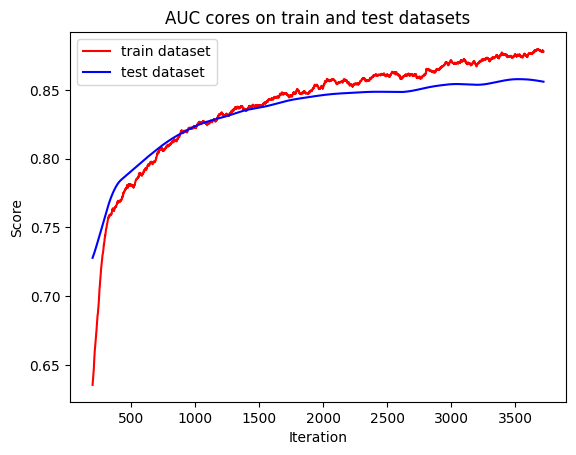

In [76]:
plot_results(train_auc_scores, test_auc_scores, roll_avg_win_size=200, title='AUC cores on train and test datasets')

## Neural net (LSTM + Dense)

In [9]:
EPOCHS = 40
BATCH_SIZE = 24
EVAL_BATCH_SIZE = 48
NUM_LAYERS = 5

LSTM_SEQ_TRUNC = 3200
LSTM_INPUT_SIZE = len(next(iter(localized_alerts_by_alert_id.values())).columns)
LSTM_OUTPUT_SIZE = 120

EVALUATION_PERIOD = 1000

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

X_train = torch.as_tensor(X_train.to_numpy().astype(float))
y_train = torch.as_tensor(y_train.to_numpy().astype(float))

X_test = torch.as_tensor(X_test.to_numpy().astype(float))
y_test = torch.as_tensor(y_test.to_numpy().astype(float))

train_data_loader = DataLoader(
    TensorDataset(
        X_train,
        y_train
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_data_loader = DataLoader(
    TensorDataset(
        X_test, 
        y_test
    ),
    batch_size=EVAL_BATCH_SIZE,
    shuffle=True
)

# The "minus 1" is because the `alerts_ids` column will be removed.
dense_net = DenseNet(input_size=len(X.columns) - 1 + LSTM_OUTPUT_SIZE).to(device=device, dtype=dtype)

lstm_net = LSTM(
    input_size=LSTM_INPUT_SIZE,
    hidden_size=LSTM_OUTPUT_SIZE,
    num_layers=NUM_LAYERS,
    dropout=0.3,
    batch_first=True
).to(device=device, dtype=dtype)

optim_dense = AdamW(dense_net.parameters(), lr=.00005)
optim_lstm = AdamW(lstm_net.parameters(), lr=.00005)

class_ratio = len(y[y == 1]) / len(y)

def loss_fun(y_true: torch.Tensor, y_pred: torch.Tensor) -> Variable:
    weight = torch.ones_like(y_true)
    weight[y_true == 1] = 1 / class_ratio

    weighted_squares = weight * (y_true - y_pred) ** 2
    return weighted_squares.mean()

def get_batch_localized_alerts(X: torch.Tensor) -> torch.Tensor:
    alert_ids = X[:, 0]

    localized_alerts = []
    for alert_id in alert_ids:
        alert_id = int(alert_id.item())
        if alert_id not in localized_alerts_by_alert_id:
            localized_alerts.append(torch.zeros(size=(LSTM_INPUT_SIZE, ), dtype=dtype, device=device))
            continue

        localized_alerts_np = localized_alerts_by_alert_id[alert_id].to_numpy()
        if len(localized_alerts_np) > LSTM_SEQ_TRUNC:
            localized_alerts_np = localized_alerts_np[-LSTM_SEQ_TRUNC:, :]

        localized_alerts.append(torch.as_tensor(localized_alerts_np.astype(float), dtype=dtype, device=device))
    
    return pad_sequence(localized_alerts, batch_first=True)

def forward_lstm_dense(X_data: torch.Tensor):           
    batch_localized_alerts = get_batch_localized_alerts(X_data)
    X_data = X_data[:, 1:]
    
    lstm_all_outs, _ = lstm_net.forward(batch_localized_alerts)
    lstm_out = lstm_all_outs[:, -1, :]

    y_pred = dense_net.forward(torch.cat([X_data, lstm_out], dim=1))
    
    return y_pred

def eval_model(dense_net, lstm_net) -> tuple[float, float, float, float]:
    
    y_true_list = []
    y_pred_list = []
    
    with torch.no_grad():
        
        lstm_net.train(False)
        dense_net.train(False)
        print('Evaluating:', end=' ')
        for n_batch, (X_batch, y_batch) in enumerate(test_data_loader):
            y_true_list.append(y_batch)
            if n_batch % 10 == 0:
                print('*', end='')
            torch.cuda.empty_cache()
            X_batch = X_batch.to(device=device, dtype=dtype)
            
            y_pred = forward_lstm_dense(X_batch)
            
            y_pred_list.append(y_pred.cpu())
        
    y_true = torch.cat(y_true_list)
    y_pred = torch.cat(y_pred_list)
    loss = loss_fun(y_true, y_pred)
    acc, bac, auc = eval_batch(y_true, y_pred)
    
    lstm_net.train(True)
    dense_net.train(True)

    return loss.item(), acc, bac, auc

In [10]:
lstm_net.train(True)
dense_net.train(True)

train_losses = []
train_acc_scores = []
train_bac_scores = []
train_auc_scores = []

test_losses = []
test_acc_scores = []
test_bac_scores = []
test_auc_scores = []

model_dump_path = DUMPS_DIR + f"/lstm_dense/{datetime.now()} "
os.makedirs(model_dump_path, exist_ok=True)
        
for epoch in range(EPOCHS):

    for n_batch, (X_batch, y_batch) in enumerate(train_data_loader):
        torch.cuda.empty_cache()
        X_batch = X_batch.to(device=device, dtype=dtype)
        y_batch = y_batch.to(device=device, dtype=dtype)
        
        optim_dense.zero_grad()
        optim_lstm.zero_grad()

        y_pred = forward_lstm_dense(X_batch)

        loss = loss_fun(y_batch, y_pred)
        acc, bac, auc = eval_batch(y_batch, y_pred)

        train_losses.append(loss.item())
        train_acc_scores.append(acc)
        train_bac_scores.append(bac)
        train_auc_scores.append(auc)
        
        loss.backward()
        optim_dense.step()
        optim_lstm.step()

        # Validate
        print('.', end='')
        if (n_batch + 1) % EVALUATION_PERIOD == 0:
            print('')
            loss, acc, bac, auc = eval_model(dense_net, lstm_net)

            test_losses.append(loss)
            test_acc_scores.append(acc)
            test_bac_scores.append(bac)
            test_auc_scores.append(auc)
    
            print(
                '\nepoch:', epoch, 'n_batch:', n_batch + 1,
                '\n:: loss :: train:', round(np.nanmean(train_losses[-EVALUATION_PERIOD:]), 3), "test: ", round(loss, 3),
                '\n:: acc :: train:', round(np.nanmean(train_acc_scores[-EVALUATION_PERIOD:]), 3), "test: ", round(acc, 3),
                '\n:: bac :: train:', round(np.nanmean(train_bac_scores[-EVALUATION_PERIOD:]), 3), "test: ", round(bac, 3),
                '\n:: auc :: train:', round(np.nanmean(train_auc_scores[-EVALUATION_PERIOD:]), 3), "test: ", round(auc, 3),
            )
        else:
            test_losses.append(np.nan)
            test_acc_scores.append(np.nan)
            test_bac_scores.append(np.nan)
            test_auc_scores.append(np.nan)
    
    torch.save(dense_net.state_dict(), model_dump_path + f"/dense_epoch_{epoch}.state")
    torch.save(lstm_net.state_dict(), model_dump_path + f"/lstm_epoch_{epoch}.state")


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

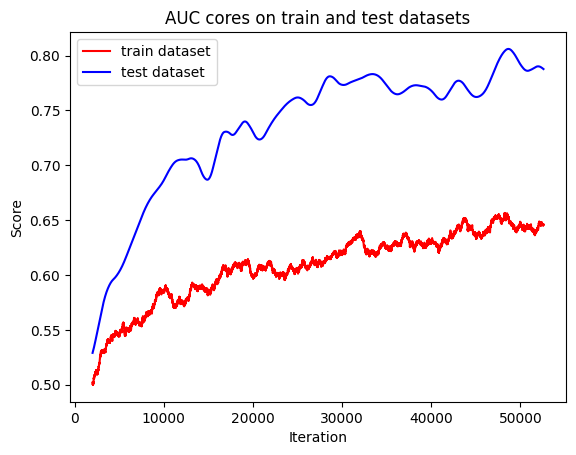

In [11]:
plot_results(train_auc_scores, test_auc_scores, roll_avg_win_size=2000, title='AUC cores on train and test datasets')

## Random Forest and statistical analysis

In [ ]:
from sklearn.ensemble import RandomForestClassifier

LOCALIZED_ALERTS_RF_DUMP_PATH = f'{DUMPS_DIR}/localized_alerts_rf_data_dump.pkl'

if os.path.exists(LOCALIZED_ALERTS_RF_DUMP_PATH):
    print(f'Processed localized alerts stats vectors found at {LOCALIZED_ALERTS_RF_DUMP_PATH}. Loading dump.')
    with open(LOCALIZED_ALERTS_RF_DUMP_PATH, 'rb') as handle:
        localized_alerts_by_alert_id = pickle.load(handle)
        
else:
    print(f'Processed localized alerts stats vectors dump not found. Preprocessing data...')
    def transform_to_stats_vectors():
        result = {}
        for i, (alert_id, localized_alerts) in enumerate(localized_alerts_by_alert_id.items()):
            
            n_alert_ids = len(localized_alerts_by_alert_id)
            
            if i % (n_alert_ids // 20) == 0:
                print(f"`localized_alerts` data transformation... {round(i / len(localized_alerts_by_alert_id) * 100)}%")
            
            stats_vector = []
            for column_name in localized_alerts.columns:
                column_np: np.ndarray = localized_alerts[column_name].to_numpy().astype(float)
                
                stats_vector.append(column_np.mean())
                stats_vector.append(column_np.min())
                stats_vector.append(column_np.max())
                stats_vector.append(column_np.std())
                
                del column_np
    
            result[alert_id] = np.asarray(stats_vector, dtype=np.float16)
        
        return result
    
    localized_alerts_stats_vectors = transform_to_stats_vectors()
    print("`localized_alerts` data transformed.")
    
    os.makedirs(DUMPS_DIR, exist_ok=True)
    
    with open(LOCALIZED_ALERTS_RF_DUMP_PATH, 'wb') as file:
        pickle.dump(
            obj=localized_alerts_stats_vectors,
            file=file,
            protocol=pickle.HIGHEST_PROTOCOL
        )
        print(f'Processed localized alerts stats vectors saved at {LOCALIZED_ALERTS_RF_DUMP_PATH}')


In [ ]:
def get_batch_localized_alerts(X: torch.Tensor) -> np.ndarray:
    alert_ids = X[:, 0]

    localized_alerts = []
    for i, alert_id in enumerate(alert_ids):
        alert_id = alert_id_to_int(alert_id)
        if alert_id not in localized_alerts_by_alert_id:
            localized_alerts.append(np.zeros(shape=(LSTM_INPUT_SIZE, )))
            continue

        localized_alerts.append(localized_alerts_stats_vectors[alert_id])
    return np.concatenate(localized_alerts)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)
print("Base data split.")

X_train = np.concatenate([X_train.to_numpy()[:, 1:], get_batch_localized_alerts(X_train.to_numpy())], axis=1)
X_test = np.concatenate([X_test.to_numpy()[:, 1:], get_batch_localized_alerts(X_train.to_numpy())], axis=1)
print("Data concatenated.")

random_forest = RandomForestClassifier(class_weight={0: class_ratio, 1:1})
y_pred = random_forest.fit_transform(X_train)
print("Random forest fitting completed.")

auc = roc_auc_score(y_train, y_pred)
print(f"Train dataset auc score: {auc}")

y_pred = random_forest.transform(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f"Test dataset auc score: {auc}")

# Generate final result on test dataset

In [12]:
X_unknown = cybersecurity_test = pd.read_csv('data/cybersecurity_test.csv', sep='|')
X_unknown.pop('client_code')

# Encode alert_ids to int (str values are invalid in torch tensors)
X_unknown['alert_ids'] = X_unknown['alert_ids'].apply(alert_id_to_int)

# Transform IPs into binary
X_ip_bin = pd.DataFrame(
    data=[encoded_ip_to_binary(ip) for ip in X_unknown.pop('ip')],
    columns=[f'ip{i}' for i in range(40)],
    index=X_unknown.index
)
X_unknown = pd.concat([X_unknown, X_ip_bin], axis=1)

# Logarithmize columns
for column_name in COLUMNS_TO_LOGARITHMIZE:
    X_unknown[column_name] = X_unknown[column_name].apply(logarithimize)

# Encode columns to one-hot
X_unknown = pd.get_dummies(X_unknown, columns=COLUMNS_TO_ONEHOTIZE, prefix_sep='$', dummy_na=True, dtype=bool)

# Drop columns absent in training data.
X_unknown.drop(columns=[col for col in X_unknown.columns if col not in X.columns], inplace=True)

# Fill one-hot columns that are missing in the `X_unknown` dataset.
for i, X_train_column in enumerate(X.columns):
    if len(X_unknown.columns) > i and list(X_unknown.columns)[i] == X_train_column:
        continue
    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore") # Inefficient, but we'll manage calling this a few times.
            X_unknown.insert(i, X_train_column, [0]*len(X_unknown))

X_unknown.head()

,alert_ids,timestamp_dist,start_hour,start_minute,start_second,correlatedcount,srcip_cd,dstip_cd,srcport_cd,dstport_cd,...,p8w$2.0,p8w$3.0,p8w$4.0,p8w$5.0,p8w$nan,p8d$1.0,p8d$2.0,p8d$3.0,p8d$4.0,p8d$nan
0,16069,0.000000,11,44,26,1.000000,1.0,1.0,1.000000,1.0,...,False,False,False,False,False,True,False,False,False,False
1,12466,0.000000,22,39,30,1.000000,1.0,1.0,1.000000,1.0,...,False,False,False,False,False,True,False,False,False,False
2,44826,0.000000,7,57,5,1.000000,1.0,1.0,1.000000,1.0,...,False,False,False,False,False,True,False,False,False,False
3,48988,0.000000,0,21,33,1.000000,1.0,1.0,1.000000,1.0,...,False,False,False,False,False,True,False,False,False,False
4,49868,17.978543,18,39,29,3.906891,1.0,1.0,3.906891,1.0,...,False,False,False,False,False,True,False,False,False,False


In [13]:
# The "minus 1" is because the `alerts_ids` column will be removed.
dense_net = DenseNet(input_size=len(X_unknown.columns) - 1 + LSTM_OUTPUT_SIZE).to(dtype=dtype, device=device)

lstm_net = LSTM(
    input_size=LSTM_INPUT_SIZE,
    hidden_size=LSTM_OUTPUT_SIZE,
    num_layers=NUM_LAYERS,
    dropout=0.3,
    batch_first=True
).to(dtype=dtype, device=device)

dense_net.load_state_dict(torch.load(model_dump_path + f"/dense_epoch_{EPOCHS - 1}.state"))
lstm_net.load_state_dict(torch.load(model_dump_path + f"/lstm_epoch_{EPOCHS - 1}.state"))

y_results = []
for i in range(0, len(X_unknown), 8):
    X_batch = X_unknown.iloc[i:i+8, :]
    y_batch = forward_lstm_dense(torch.as_tensor(X_batch.to_numpy().astype(float), dtype=dtype, device=device))
    y_results.extend(y_batch.tolist())

y_results[:10]

[[0.5573563575744629],
 [0.5034943222999573],
 [0.6352086663246155],
 [0.5542920827865601],
 [0.6098483204841614],
 [0.6344156861305237],
 [0.5939103364944458],
 [0.6026078462600708],
 [0.6200844645500183],
 [0.6026825904846191]]